# Predicting Gender of Shughni Nouns Using Machine Learning Methods

## Modules

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, json
from tqdm import tqdm

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.sparse import hstack

import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
import os

import warnings
warnings.filterwarnings("ignore")

## Data preparation

### Loading the data

In [2]:
data = pd.merge(
    pd.read_csv("res_subset_sem.csv"),
    pd.read_csv("res_subset_forms.csv").drop_duplicates(subset="unit_id", keep="first"),
    on="unit_id", how="left"
)

data = data[data["meaning_gender"].isin(["m", "f"])]
#data = data.sample(n=1000, random_state=42)

### Extracting the features

In [3]:
tuned_params = {}

y_pred = {}   # dictionary with predicted values from different features and models
results = {}  # classification reports from different features and models
models = {}   # models used in predictions from different features (necessary to show feature importances)

In [4]:
word_endings = {}
x_feature_values = {}

In [5]:
sem_features = ['indspec', 'large', 'sex=f', 'animals', 'water',
                'trees', 'fruit', 'techtransport', 'culturalprod.',
                'massabstr', 'small', 'name', 'householdobjects',
                'food', 'drink', 'plants', 'events', 'pos', 'neg',
                'weather', 'bodyparts', 'buildings', 'landscape', 'sex=m',
                'milkprod.', 'vegetables', 'footwear', 'sicknesses']

vowels = ("a", "ā", "e", "ê", "i", "ī", "o", "u", "ū", "ů")

bad_letters = [("x̌", "X"), ("ɣ̌", "G"), ("ǰ", "j")]

In [6]:
def extract_n_letters(word, n):
    for pair in bad_letters:
        word = re.sub(pair[0], pair[1], word)
    
    if len(word)<n:
        return ""
    
    suffix = ""
    for i in range(len(word)-1, len(word)-n-1, -1):
        if word[i] == "-":
            return ""
        suffix = word[i] + suffix

    for pair in bad_letters:
        suffix = re.sub(pair[1], pair[0], suffix)
    return suffix
    

def last_vowel(word):
    for i in range(len(word)-1, -1, -1):
        if word[i] in vowels:
            return word[i]
    return None

In [7]:
for n in range(2, 7):
    data[f"last_{n}"] = data["form"].apply(lambda x: extract_n_letters(x, n))
    
data["last_vowel"] = data["form"].apply(lambda x: last_vowel(x))

In [8]:
data.head(5)

,meaning_id,unit_id,full_entry,meaning,meaning_with_examples,article_gender,meaning_gender,label_id,indspec,large,...,gloss_id,gloss,form,source,last_2,last_3,last_4,last_5,last_6,last_vowel
0,1249,671,"АБЛАГАРИ, АБЛАГИ м. глупость, дурость; ш. абла...","глупость, дурость","глупость, дурость; не делай глупости; кто тебя...",m,m,NaN,0,0,...,20,word,ablagari,2,ri,ari,gari,agari,lagari,i
1,1258,677,"АБОТĀ 1. 1) глупец, дурак, дурачок; ш. йу абот...","глупец, дурак, дурачок","глупец, дурак, дурачок; он дурак, несет (все),...",m,m,NaN,1,0,...,20,word,abotā,2,tā,otā,botā,abotā,,ā
2,1265,681,АБРАЙЕҶ м. ткань для лицевой стороны одежды.,ткань для лицевой стороны одежды,ткань для лицевой стороны одежды,m,m,NaN,1,0,...,20,word,abrayeǰ,2,eǰ,yeǰ,ayeǰ,rayeǰ,brayeǰ,e
3,1271,687,"шб. АБРЕХ̌УМ, ш. тж. ВИРЕХ̌УМ м. 1) шелк, шелк...","шелк, шелковая ткань; шелковая одежда","шелк, шелковая ткань; шелковая одежда; шелкова...",m,m,10.0,1,0,...,20,word,abrex̌um,2,um,x̌um,ex̌um,rex̌um,brex̌um,u
4,1274,689,"А́БРИ, (Ҳ)А́БРÊ м. облако, туча; ш. йида а́бри...","облако, туча","облако, туча; вот опять появились тучи; облако...",m,m,NaN,1,1,...,20,word,abri,2,ri,bri,abri,,,i


<AxesSubplot:xlabel='meaning_gender', ylabel='Count'>

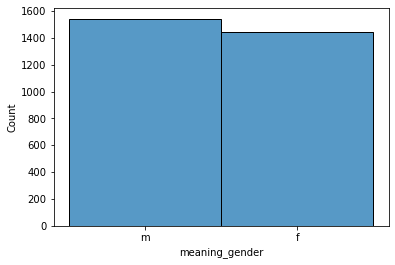

In [11]:
sns.histplot(data["meaning_gender"])

### Exploring the features

#### Last vowel

<Axes: xlabel='last_vowel', ylabel='Count'>

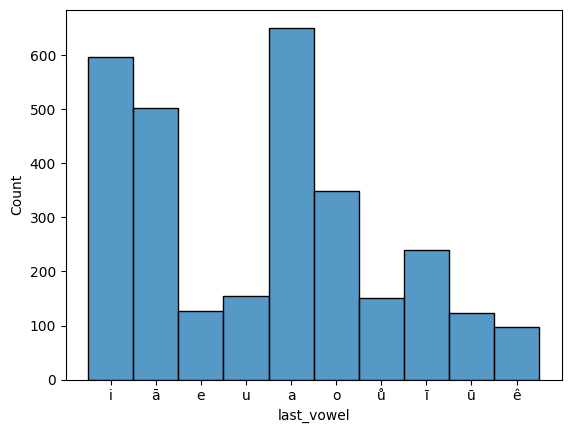

In [12]:
sns.histplot(data["last_vowel"])

<Axes: xlabel='meaning_gender', ylabel='Count'>

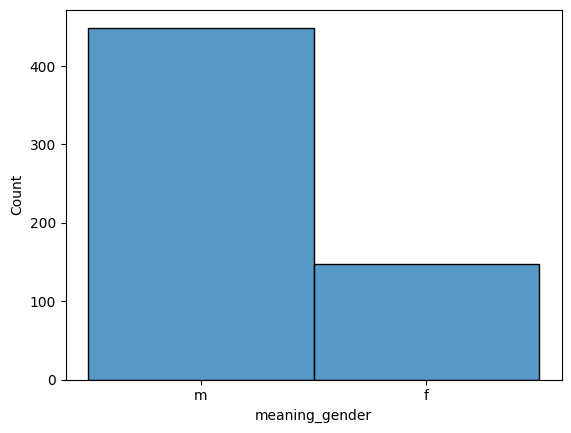

In [13]:
sns.histplot(data[data["last_vowel"]=="i"]["meaning_gender"])

<Axes: xlabel='meaning_gender', ylabel='Count'>

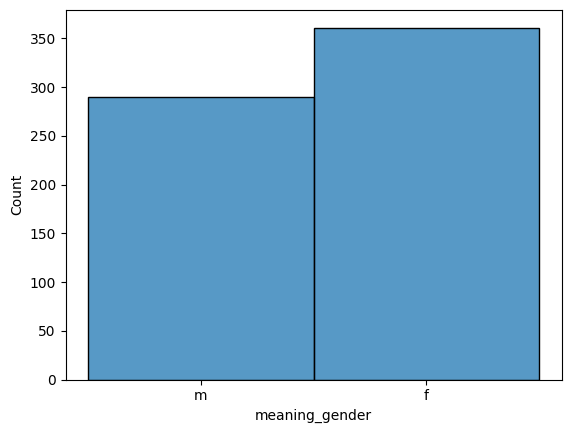

In [14]:
sns.histplot(data[data["last_vowel"]=="a"]["meaning_gender"])

#### Last 2

<Axes: xlabel='last_2', ylabel='count'>

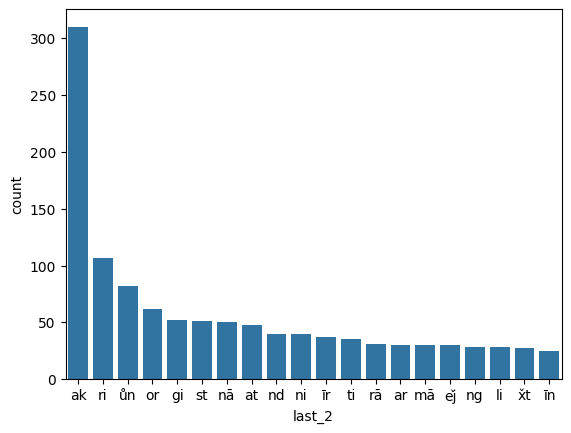

In [21]:
sns.barplot(data["last_2"].value_counts()[:20])

<Axes: xlabel='meaning_gender', ylabel='Count'>

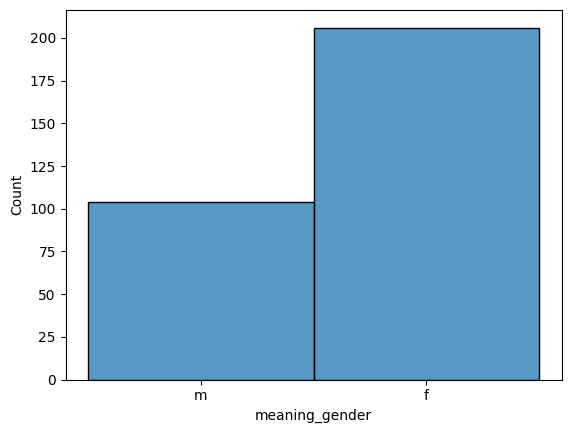

In [22]:
sns.histplot(data[data["last_2"]=="ak"]["meaning_gender"])

<Axes: xlabel='meaning_gender', ylabel='Count'>

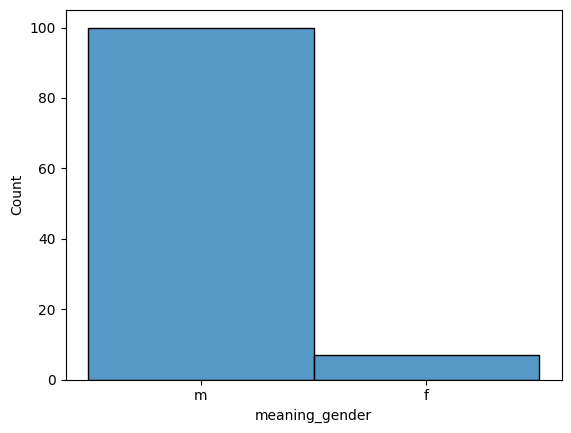

In [23]:
sns.histplot(data[data["last_2"]=="ri"]["meaning_gender"])

#### Semantic features

<Axes: xlabel='meaning_gender', ylabel='Count'>

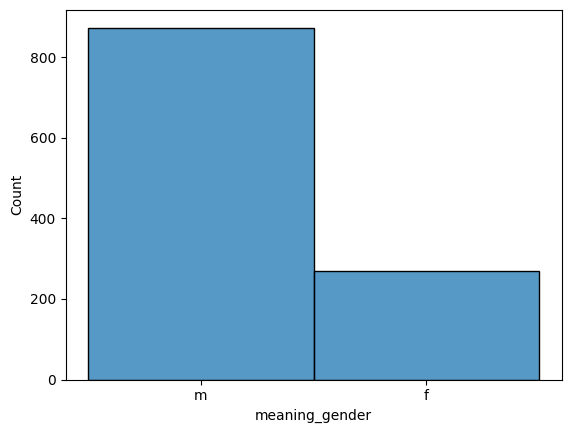

In [24]:
sns.histplot(data[data["mass,abstr"]==1]["meaning_gender"])

<Axes: xlabel='meaning_gender', ylabel='Count'>

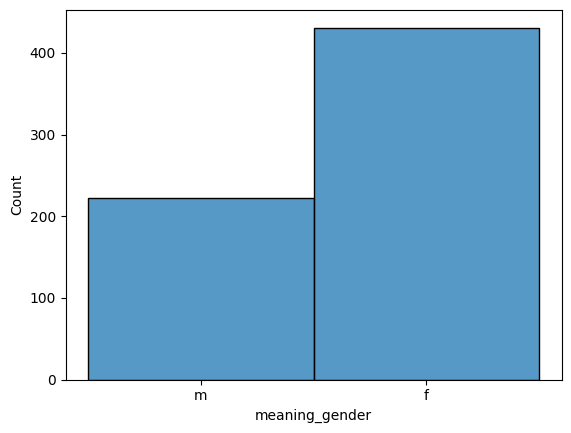

In [25]:
sns.histplot(data[data["household objects"]==1]["meaning_gender"])

## Training preparation

### Training functions

In [56]:
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    _y_pred = model.predict(X_test)
    return _y_pred, classification_report(y_test, _y_pred, output_dict=True)


def train_models(X_train, y_train, settings):
    if not settings["MODELS_TO_TRAIN"]:
        settings["MODELS_TO_TRAIN"] = ("mnb", "rfc", "dtc", "log")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=settings["TEST_SIZE"],
        random_state=settings["RANDOM_STATE"]
    )
    _y_pred, _results, _models = {}, {}, {}
    
    if "mnb" in settings["MODELS_TO_TRAIN"]:
        _models["mnb"] = MultinomialNB(
            alpha=settings["MNB_ALPHA"], fit_prior=settings["MNB_FIT_PRIOR"]
        )
        _y_pred["MultinomialNB"], _results["MultinomialNB"] = fit_predict(
            _models["mnb"], X_train, y_train, X_test, y_test)
        _y_train_pred = _models["mnb"].predict(X_train)
        _results["MultinomialNB"]["accuracy_train"] = accuracy_score(y_train, _y_train_pred)
    
    if "rfc" in settings["MODELS_TO_TRAIN"]:
        _models["rfc"] = RandomForestClassifier(
            max_depth=settings["RFC_MAX_DEPTH"],
            min_samples_leaf=settings["RFC_MIN_SAMPLES_LEAF"]
        )
        _y_pred["RandomForestClassifier"], _results["RandomForestClassifier"] = fit_predict(
            _models["rfc"], X_train, y_train, X_test, y_test)
        _results["RandomForestClassifier"]["accuracy_train"] = _models["rfc"].score(X_train, y_train)
    
    if "dtc" in settings["MODELS_TO_TRAIN"]:
        _models["dtc"] = DecisionTreeClassifier(
            max_depth=settings["DTC_MAX_DEPTH"],
            min_samples_leaf=settings["DTC_MIN_SAMPLES_LEAF"]
        )
        _y_pred["DecisionTreeClassifier"], _results["DecisionTreeClassifier"] = fit_predict(
            _models["dtc"], X_train, y_train, X_test, y_test)
        _results["DecisionTreeClassifier"]["accuracy_train"] = _models["dtc"].score(X_train, y_train)
    
    if "log" in settings["MODELS_TO_TRAIN"]:
        _models["log"] = LogisticRegression(
            penalty=settings["LOG_PENALTY"],
            C=settings["LOG_C"],
            solver=settings["LOG_SOLVER"]
        )
        _y_pred["LogisticRegression"], _results["LogisticRegression"] = fit_predict(
            _models["log"], X_train, y_train, X_test, y_test)
        _y_train_pred = _models["log"].predict(X_train)
        _results["LogisticRegression"]["accuracy_train"] = accuracy_score(y_train, _y_train_pred)

    if "catb" in settings["MODELS_TO_TRAIN"]:
        _models["catb"] = CatBoostClassifier(
            iterations=settings["CATB_ITERATIONS"],
            learning_rate=settings["CATB_LEARNING_RATE"],
            depth=settings["CATB_DEPTH"],
            silent=True
        )
        _y_pred["CatBoostClassifier"], _results["CatBoostClassifier"] = fit_predict(
            _models["catb"], X_train, y_train, X_test, y_test)
        _results["CatBoostClassifier"]["accuracy_train"] = _models["catb"].score(X_train, y_train)

    return _y_pred, _results, _models


def show_accuracy(results):
    return {key: round(results[key]["accuracy"], 4) for key in results.keys()}


def show_class_score(results, score_name):
    class_score = {}
    for key in results.keys():
        class_score[key] = {}
        for class_ in ("f", "m"):
            class_score[key][class_] = round(results[key][class_][score_name], 4) 
    return class_score


def show_overfitting(results, model):
    accs = {}
    accs["accuracy_test"] = round(results[model]["accuracy"], 4)
    if "accuracy_train" in results[model]:
        accs["accuracy_train"] = round(results[model]["accuracy_train"], 4)
    return accs


def show_importances(model, features, n=20):
    indices = np.argsort(model.feature_importances_)[::-1]
    importances = []
    for f in range(min(n, len(features))):
        importances.append({
            "feature": features[indices[f]],
            "importance": model.feature_importances_[indices[f]]
        })
    return pd.DataFrame(importances, index=range(1, min(n, len(features))+1))

In [10]:
def dtc_tree(model, feature_names):
    plt.figure(figsize=(40, 20))
    plot_tree(model, filled=True, feature_names=feature_names,
          class_names=True, impurity=False, label="none", fontsize=16)
    plt.show()

### Transforming x-values

In [11]:
def transform_VECTORIZER(feature):
    return CountVectorizer().fit_transform(data[feature])


def transform_OHE(feature):
    ohe = OneHotEncoder()
    return ohe.fit_transform(data[[feature]]), ohe.get_feature_names_out()


model_path = 'fasttext_wiki_news_subwords_300.kv'


def load_fasttext_model():
    if os.path.exists(model_path):
        model = KeyedVectors.load(model_path)  
    else:
        model = api.load("fasttext-wiki-news-subwords-300")
        model.save(model_path)  
    return model

def transform_FASTTEXT(feature): 
    
    model = load_fasttext_model()
    
    def vectorize_text(text):
        words = simple_preprocess(text, deacc=True)
        word_vectors = [model[word] for word in words if word in model]
        if not word_vectors:
            return np.zeros(model.vector_size)
        return np.mean(word_vectors, axis=0)
    return np.array([vectorize_text(text) for text in data[feature]])

In [12]:
def transform_x_values(_x_feature_values, _word_endings):
    for _FEATURE in ("meaning",):
        _x_feature_values[_FEATURE] = transform_VECTORIZER(_FEATURE)
    for _FEATURE in ("meaning_with_examples",):
        _x_feature_values["meaning_with_examples_vec"] = transform_VECTORIZER(_FEATURE)
    for _FEATURE in ("meaning_with_examples",):
        _x_feature_values["meaning_with_examples_pretrained"] = transform_FASTTEXT(_FEATURE)
    for _FEATURE in ("last_vowel",):
        _x_feature_values[_FEATURE], _vowels_feature_names = transform_OHE(_FEATURE)
    for _FEATURE in ("last_2", "last_3", "last_4"):
        _x_feature_values[_FEATURE], _word_endings[_FEATURE] = transform_OHE(_FEATURE)
    return _x_feature_values, _vowels_feature_names, _word_endings


def stack_x(features_):
    features_ = features_.split(" + ")
    features_ = [x_feature_values[f] for f in features_]
    return hstack(features_)

In [13]:
x_feature_values, vowels_feature_names, word_endings = transform_x_values(x_feature_values, word_endings)
x_feature_values["sem_features"] = data[sem_features]

### Fine-tuning

In [17]:
def grid_search(model_, params_, X_train, X_test, y_train, y_test):
    gs = GridSearchCV(model_, params_, cv=5, scoring='f1_weighted')
    gs.fit(X_train, y_train)

    print("Best parameters:", gs.best_params_)
    #print("Best score (f1 weighted):", round(gs.best_score_, 3))

    best_model = gs.best_estimator_
    f1_weighted = f1_score(y_test, best_model.predict(X_test), average='weighted')
    print("Test F1-Weighted:", round(f1_weighted, 3), "\n")

    return best_model, gs.best_params_

In [18]:
params_to_tune = {
    "dtc": {
        'max_depth': [5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 5, 10]},
    "rfc": {
        'max_depth': [5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 5, 10]},
    "mnb": {
        'alpha': [0, 0.5, 1, 2, 5],
        'fit_prior': [True, False]},
    "log": {
        'penalty': ["l1", "l2"],
        'C': [0, 0.5, 1, 1.5, 2],
        'solver': ["liblinear"]}
}

def find_best_params(model_name, feature):
    params_ = params_to_tune[model_name]
    if model_name == "dtc":
        model_ = DecisionTreeClassifier()
    elif model_name == "rfc":
        model_ = RandomForestClassifier()
    elif model_name == "mnb":
        model_ = MultinomialNB()
    elif model_name == "log":
        model_ = LogisticRegression()

    print(f"Feature: {feature} === Model: {model_}")
    
    return grid_search(model_, params_, *train_test_split(
        x_feature_values[feature], data["meaning_gender"],
        test_size=SETTINGS["TEST_SIZE"], random_state=SETTINGS["RANDOM_STATE"]))

In [23]:
SETTINGS = {
    "RANDOM_STATE": 42,
    "TEST_SIZE": 0.2,
    "MODELS_TO_TRAIN": ["mnb", "rfc", "dtc", "log",]
}

In [24]:
tune_features = ("last_vowel", "last_2", "meaning", "sem_features")

for feature in tune_features:
    models[feature] = {}
    tuned_params[feature] = {}
    for model in SETTINGS["MODELS_TO_TRAIN"]:
        models[feature][model], tuned_params[feature][model] = find_best_params(model, feature)

Feature: last_vowel === Model: MultinomialNB()
Best parameters: {'alpha': 0, 'fit_prior': False}
Test F1-Weighted: 0.577 

Feature: last_vowel === Model: RandomForestClassifier()
Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test F1-Weighted: 0.577 

Feature: last_vowel === Model: DecisionTreeClassifier()
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test F1-Weighted: 0.577 

Feature: last_vowel === Model: LogisticRegression()
Best parameters: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Test F1-Weighted: 0.577 

Feature: last_2 === Model: MultinomialNB()
Best parameters: {'alpha': 0, 'fit_prior': True}
Test F1-Weighted: 0.639 

Feature: last_2 === Model: RandomForestClassifier()
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10}
Test F1-Weighted: 0.594 

Feature: last_2 === Model: DecisionTreeClassifier()
Best parameters: {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_s

## Training

In [76]:
SETTINGS = {
    "RANDOM_STATE": 42,
    "TEST_SIZE": 0.2,
    
    "DTC_MAX_DEPTH": None,      #80
    "DTC_MIN_SAMPLES_LEAF": 1,  #3
    "RFC_MAX_DEPTH": None,      #50
    "RFC_MIN_SAMPLES_LEAF": 1,  #3
    "MNB_ALPHA": 1,             #5
    "MNB_FIT_PRIOR": True,      #True
    "LOG_PENALTY": "l2",        #l1
    "LOG_C": 1,                 #1
    "LOG_SOLVER": "liblinear",  #liblinear
     "CATB_ITERATIONS": 100,
    "CATB_LEARNING_RATE": 0.1,
    "CATB_DEPTH": 6,
    "MODELS_TO_TRAIN": ["rfc", "dtc", "log", "catb"]
}

# hyperparameters were picked using GridSearchCV
# out of all tested options which test score to train score was <= 5%
# the parameters with the highest test score were chosen

In [77]:
for FEATURE in (["meaning", "meaning_with_examples_vec", "meaning_with_examples_pretrained", "last_vowel", "sem_features", "last_2", "last_3", "last_4"]):
    y_pred[FEATURE], results[FEATURE], models[FEATURE] = train_models(
        x_feature_values[FEATURE], data["meaning_gender"], SETTINGS)
#show_importances(models["last_2"]["dtc"], word_endings["last_2"], 5)

In [78]:
#dtc_tree(models["sem_features"]["dtc"], sem_features)

In [79]:
stacked_features = (
    "meaning + last_vowel",
    "meaning + last_2",
    "sem_features + last_vowel",
    "sem_features + last_2",
    "sem_features + meaning",
    "sem_features + last_vowel + meaning",
    "sem_features + last_vowel + meaning_with_examples_vec",
    "sem_features + last_2 + meaning"
)

for FEATURE in tqdm(stacked_features):
    y_pred[FEATURE], results[FEATURE], models[FEATURE] = train_models(
        stack_x(FEATURE), data["meaning_gender"], SETTINGS)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:38<00:00,  4.87s/it]


In [154]:
#dtc_tree(models["sem_features + last_vowel"]["dtc"], sem_features+vowels_feature_names.tolist())

## Analysis

### Overfitting

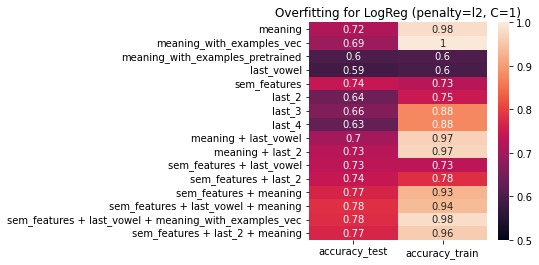

In [80]:
overfitting_log = {}
for key in results:
    overfitting_log[key] = show_overfitting(results[key], "LogisticRegression")
overfitting_log = pd.DataFrame(overfitting_log).transpose()

plt.figure(figsize=(4, 4))
sns.heatmap(overfitting_log, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for LogReg (penalty={SETTINGS['LOG_PENALTY']}, C={SETTINGS['LOG_C']})")
#plt.savefig(f"overfitting_log_{str(SETTINGS['LOG_PENALTY'])}_{str(SETTINGS['LOG_C'])}.png", bbox_inches='tight')
plt.show()

In [32]:
round((overfitting_log["accuracy_train"] - overfitting_log["accuracy_test"]) / overfitting_log["accuracy_train"] * 100, 2)

meaning                                                  27.15
meaning_with_examples_vec                                30.31
meaning_with_examples_pretrained                          0.80
last_vowel                                                1.58
sem_features                                             -2.15
last_2                                                   14.43
last_3                                                   24.26
last_4                                                   27.99
meaning + last_vowel                                     27.07
meaning + last_2                                         25.36
sem_features + last_vowel                                -0.01
sem_features + last_2                                     4.91
sem_features + meaning                                   17.55
sem_features + last_vowel + meaning                      16.39
sem_features + last_vowel + meaning_with_examples_vec    20.81
sem_features + last_2 + meaning                        

In [17]:
overfitting_mnb = {}
for key in results:
    overfitting_mnb[key] = show_overfitting(results[key], "MultinomialNB")
overfitting_mnb = pd.DataFrame(overfitting_mnb).transpose()

plt.figure(figsize=(4, 4))
sns.heatmap(overfitting_mnb, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for MNB (alpha={SETTINGS['MNB_ALPHA']}, fit_prior={SETTINGS['MNB_FIT_PRIOR']})")
plt.savefig(f"overfitting_mnb_{str(SETTINGS['MNB_ALPHA'])}_{str(SETTINGS['MNB_FIT_PRIOR'])}.png", bbox_inches='tight')
plt.show()

In [18]:
#round((overfitting_mnb["accuracy_train"] - overfitting_mnb["accuracy_test"]) / overfitting_mnb["accuracy_train"] * 100, 2)

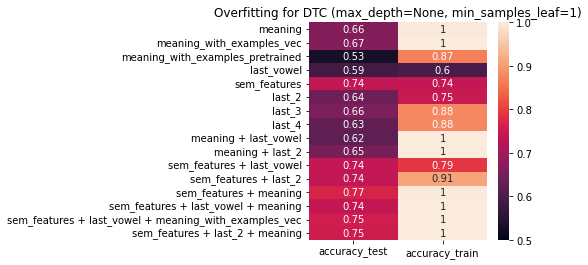

In [35]:
overfitting_dtc = {}
for key in results:
    overfitting_dtc[key] = show_overfitting(results[key], "DecisionTreeClassifier")
overfitting_dtc = pd.DataFrame(overfitting_dtc).transpose()

plt.figure(figsize=(4, 4))
sns.heatmap(overfitting_dtc, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for DTC (max_depth={SETTINGS['DTC_MAX_DEPTH']}, min_samples_leaf={SETTINGS['DTC_MIN_SAMPLES_LEAF']})")
#plt.savefig(f"overfitting_dtc_{str(SETTINGS['DTC_MAX_DEPTH'])}_{str(SETTINGS['DTC_MIN_SAMPLES_LEAF'])}.png", bbox_inches='tight')
plt.show()

In [40]:
round((overfitting_dtc["accuracy_train"] - overfitting_dtc["accuracy_test"]) / overfitting_dtc["accuracy_train"] * 100, 2)

meaning                                34.06
last_vowel                              1.58
last_2                                 13.99
sem_features                            1.65
meaning + last_2                       35.45
meaning + last_vowel                   36.42
sem_features + last_2                  18.24
sem_features + last_vowel               7.75
sem_features + meaning                 23.89
sem_features + last_2 + meaning        25.59
sem_features + last_vowel + meaning    25.72
dtype: float64

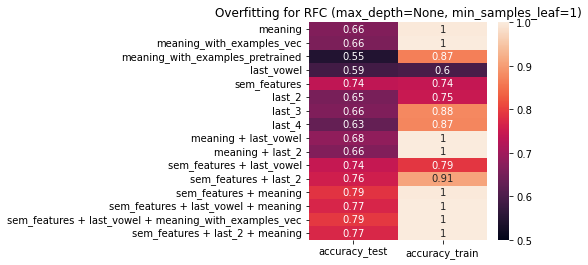

In [36]:
overfitting_rfc = {}
for key in results:
    overfitting_rfc[key] = show_overfitting(results[key], "RandomForestClassifier")
overfitting_rfc = pd.DataFrame(overfitting_rfc).transpose()

plt.figure(figsize=(4, 4))
sns.heatmap(overfitting_rfc, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for RFC (max_depth={SETTINGS['RFC_MAX_DEPTH']}, min_samples_leaf={SETTINGS['RFC_MIN_SAMPLES_LEAF']})")
#plt.savefig(f"overfitting_rfc_{str(SETTINGS['RFC_MAX_DEPTH'])}_{str(SETTINGS['RFC_MIN_SAMPLES_LEAF'])}.png", bbox_inches='tight')
plt.show()

In [42]:
round((overfitting_rfc["accuracy_train"] - overfitting_rfc["accuracy_test"]) / overfitting_rfc["accuracy_train"] * 100, 2)

meaning                                34.03
last_vowel                              6.50
last_2                                 14.87
sem_features                            1.65
meaning + last_2                       33.28
meaning + last_vowel                   33.92
sem_features + last_2                  17.32
sem_features + last_vowel               7.12
sem_features + meaning                 21.51
sem_features + last_2 + meaning        22.41
sem_features + last_vowel + meaning    22.71
dtype: float64

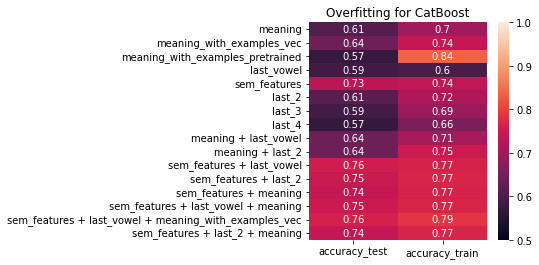

In [81]:
overfitting_catb = {}
for key in results:
    overfitting_catb[key] = show_overfitting(results[key], "CatBoostClassifier")
overfitting_catb = pd.DataFrame(overfitting_catb).transpose()

plt.figure(figsize=(4, 4))
sns.heatmap(overfitting_catb, vmin=0.5, vmax=1, annot=True)
plt.title(f"Overfitting for CatBoost")# plt.savefig(f"overfitting_catboost.png", bbox_inches='tight')
plt.show()

### Accuracy

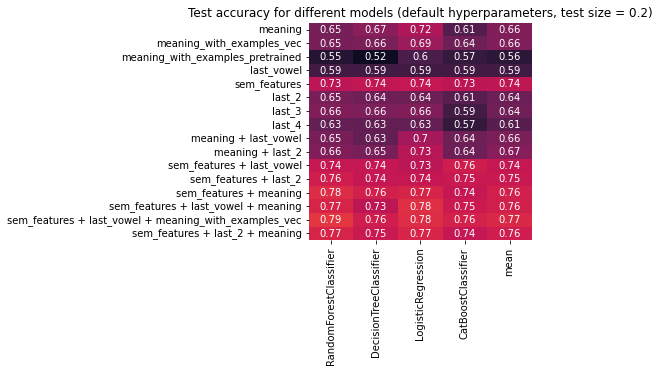

In [82]:
accuracies = {}
for key in results:
    accuracies[key] = show_accuracy(results[key])
accuracies = pd.DataFrame(accuracies).transpose()
accuracies["mean"] = accuracies[accuracies.columns.values].mean(axis=1)
#accuracies = accuracies.sort_values(by="mean")

plt.figure(figsize=(4, 4))
sns.heatmap(accuracies, vmin=0.5, vmax=1, annot=True, cbar=False)
plt.title(f"Test accuracy for different models (default hyperparameters, test size = {SETTINGS['TEST_SIZE']})")
plt.show()

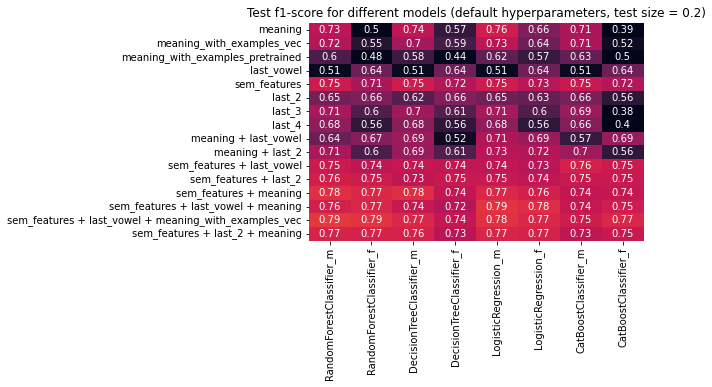

In [83]:
SCORE_NAME = "f1-score"

class_scores = {}
for key in results:
    class_scores[key] = {}
    for model_ in show_class_score(results[key], SCORE_NAME).items():
        for class_ in ("m", "f"):
            class_scores[key][f'{model_[0]}_{class_}'] = model_[1][class_]

class_scores = pd.DataFrame(class_scores).transpose()
#class_scores["mean"] = class_scores[class_scores.columns.values].mean(axis=1)
#class_scores = class_scores.sort_values(by="mean").drop("mean", axis=1)

plt.figure(figsize=(6, 4))
sns.heatmap(class_scores, vmin=0.5, vmax=1, annot=True, cbar=False)
plt.title(f"Test {SCORE_NAME} for different models (default hyperparameters, test size = {SETTINGS['TEST_SIZE']})")
plt.show()

*Ниже этой строчки я кажется ничего не трогал!*

In [ ]:
X = data['meaning']
y = data['grammar']

# Векторизация определений слов
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Подготовка семантических признаков
X_semantic = data[['ind,spec', 'large', 'sex=f', 'animals', 'water', 'trees', 'fruit', 'tech,transport', 
                   'cultural prod.', 'mass,abstr', 'small', 'name', 'household objects', 'food', 'drink', 
                   'plants', 'events', 'pos', 'neg', 'weather', 'bodyparts', 'buildings', 'landscape', 
                   'sex=m', 'milk prod.', 'vegetables', 'footwear', 'sicknesses']]

vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(3,3))
X3 = vectorizer3.fit_transform(data['last_3_letters'])

X_combined = hstack((X_vec, X_semantic, X3))

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

rfc_c = RandomForestClassifier()
rfc_c.fit(X_train, y_train)

y_pred = rfc_c.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Decision Tree model: {accuracy}")

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of Random Forest Classifier model: {accuracy_rf}")

In [ ]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)

y_pred_logreg = logreg_classifier.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy of Logistic Regression classifier model: {accuracy_logreg}")

In [ ]:
np.random.seed(42)
X = data['meaning']
y = data['grammar']

# Векторизация определений слов
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Подготовка семантических признаков
X_semantic = data[['ind,spec', 'large', 'sex=f', 'animals', 'water', 'trees', 'fruit', 'tech,transport', 
                   'cultural prod.', 'mass,abstr', 'small', 'name', 'household objects', 'food', 'drink', 
                   'plants', 'events', 'pos', 'neg', 'weather', 'bodyparts', 'buildings', 'landscape', 
                   'sex=m', 'milk prod.', 'vegetables', 'footwear', 'sicknesses']]

vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(3,3))
X3 = vectorizer3.fit_transform(data['last_3_letters'])

X_combined = hstack((X_vec, X_semantic, X3))

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

rfc_c = RandomForestClassifier()
rfc_c.fit(X_train, y_train)

y_pred = rfc_c.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Decision Tree model: {accuracy}")

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of Random Forest Classifier model: {accuracy_rf}")

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, y_train)

y_pred_mlp = mlp_classifier.predict(X_test)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy of MLP Classifier model: {accuracy_mlp}")

In [ ]:
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train, y_train)

y_pred_logreg = logreg_classifier.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy of Logistic Regression classifier model: {accuracy_logreg}")

In [ ]:
print(classification_report(y_test, y_pred_logreg))

In [ ]:
cml = confusion_matrix(y_test, y_pred_logreg, labels=['f',  'fm','m',  ])
cml

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cml, annot=True, fmt='d', xticklabels=['f',  'fm','m',  ], yticklabels=['f',  'fm','m',  ], cmap='Blues')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.title('Confusion Matrix')
plt.show()